# Liesel-GAM Demo Notebook

## Setup and Imports

The rpy2 Jupyter cell magic is used here only to pull the mcycle dataframe from R

In [3]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [4]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from smoothcon import SmoothCon

import liesel_gam as gam

In [5]:
mcycle = None
%R -o mcycle library(MASS); data(mcycle)

array(['mcycle'], dtype='<U6')

In [6]:
mcycle.head()

,times,accel
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7


## Model Definition

The `gam.Sum()` objects are special `lsl.Var` classes. They allow users to add 
variables with the `+=` operator, and always represent the sum of all their inputs.
Thus, they conveniently represent additive predictors.

### Setup response model

In [7]:
loc = gam.Sum("$\\mu$")
log_scale = gam.Sum("$\\log \\sigma$")


scale = lsl.Var.new_calc(jnp.exp, log_scale, name="$\\sigma$")

accel = lsl.Var.new_obs(
    value=mcycle.accel.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="accel",
)

### Add intercepts

In [8]:
loc += lsl.Var.new_param(
    value=0.0,
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
    name="$\\beta_0$",
)

log_scale += lsl.Var.new_param(
    value=0.0,
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
    name="$\\gamma_0$",
)

### Initialize inverse smoothing parameters

Here, we initialize the inverse smoothing parameters. Setting it up like this allows us
to freely exchange their priors and/or their inference information, if we want or need
to.

In [9]:
m_times_tau2 = lsl.Var.new_param(
    value=1.0,
    distribution=lsl.Dist(tfd.InverseGamma, concentration=2.0, scale=0.5),
    name="$\\tau^2_m$",
)
m_times_tau = lsl.Var.new_calc(jnp.sqrt, m_times_tau2, name="$\\tau_m$")
m_times_tau2_log = m_times_tau2.transform(
    tfb.Exp(),
    name="$\\log \\tau^2_m$",  # New in liesel v0.4.0
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
)


s_times_tau2 = lsl.Var.new_param(
    1.0, lsl.Dist(tfd.InverseGamma, concentration=2.0, scale=0.5), name="$\\tau^2_s$"
)
s_times_tau = lsl.Var.new_calc(jnp.sqrt, s_times_tau2, name="$\\tau_s$")
s_times_tau2_log = s_times_tau2.transform(
    tfb.Exp(),
    name="$\\log \\tau^2_s$",  # New in liesel v0.4.0
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
)

### Pull basis and penalty from mgcv

Here, we pull the basis matrix and penalty from mgcv. Note that, using the 
`SmoothCon` class, you only need to execute Python code. No manual R call and 
convesion to Python objects necessary.

In [10]:
stimes = SmoothCon(
    # this string is the R code you *would* call in mgcv for this term
    spec="s(times, bs='ps', k=20, m=c(3,2))",
    data=mcycle,
)

### Initialize smooth terms

The `gam.SmoothTerm` can be used to represent isotropic smooths. It is a `lsl.Var` that
will automatically initialize a fitting coefficient variabel with a 
potentially singular multivariate normal prior given the penalty matrix.

In [11]:
# we use the same basis for both smooths here
times_basis = lsl.Var.new_obs(stimes.basis, name="B(times)")

loc += gam.SmoothTerm(
    basis=times_basis,
    penalty=stimes.penalty,
    scale=m_times_tau,
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
    name="m(times)",
    coef_name="$\\beta$",  # I'm using LaTeX math syntax for pretty rendering in plots
)

log_scale += gam.SmoothTerm(
    basis=times_basis,
    penalty=stimes.penalty,
    scale=s_times_tau,
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
    name="s(times)",
    coef_name="$\\gamma$",
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="accel_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="B(times)_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


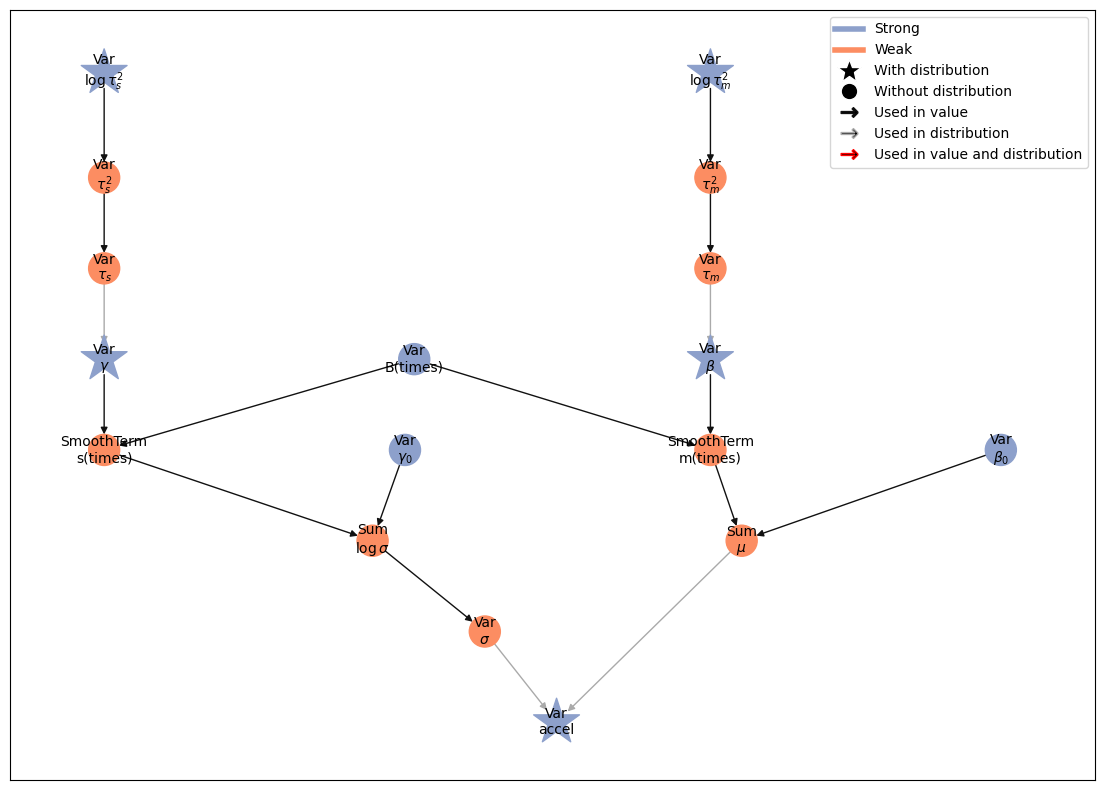

In [12]:
model = lsl.Model([accel])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [13]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=2000,
        posterior_duration=1000,
        init_duration=300,
        term_duration=300,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\gamma$', '$\\log \\tau^2_s$', '$\\gamma_0$', '$\\beta$', '$\\log \\tau^2_m$', '$\\beta_0$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 300 transitions, 25 jitted together
100%|████████████████████████████████████████| 12/12 [00:14<00:00,  1.18s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 50, 57, 47, 43 / 300 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 2, 3, 3, 3 / 300 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_02: 3, 3, 1, 1 / 300 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 169, 35, 61, 165 / 300 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 4, 5, 3, 3 / 300 transitions
liesel.goose.engine - WARNING -

### MCMC summary

In [14]:
summary = gs.Summary(results)
summary

Parameter summary:

                          kernel       mean         sd     q_0.05      q_0.5  \
parameter       index                                                          
$\beta$         (0,)   kernel_03  -7.933714  12.303022 -28.274937  -7.673618   
                (1,)   kernel_03  14.581852  11.601341  -3.743015  13.976955   
                (2,)   kernel_03   6.311780  11.173712 -12.016488   6.308675   
                (3,)   kernel_03   4.869296  11.204151 -12.907351   4.591576   
                (4,)   kernel_03  -7.092866  10.621125 -25.044432  -6.711920   
                (5,)   kernel_03 -10.320790  10.425021 -27.659030 -10.316641   
                (6,)   kernel_03   5.746847   9.829079 -10.413636   5.890516   
                (7,)   kernel_03  -5.266916   9.161413 -20.351260  -5.148953   
                (8,)   kernel_03  13.981827   8.350584   0.311495  13.847163   
                (9,)   kernel_03  24.612421   8.088791  11.539651  24.476597   
                (10,)  kernel_03  -2.371494   6.667955 -13.145560  -2.323014   
                (11,)  kernel_03 -25.027033   6.126281 -35.190589 -24.935717   
                (12,)  kernel_03  12.580379   4.918200   4.388762  12.658230   
                (13,)  kernel_03  -8.755826   3.974440 -15.324157  -8.726178   
                (14,)  kernel_03 -12.949740   2.958774 -17.884998 -12.884124   
                (15,)  kernel_03  -2.239950   2.007911  -5.532681  -2.238512   
                (16,)  kernel_03   2.666833   1.091514   0.849897   2.701479   
                (17,)  kernel_03   0.983332   0.428479   0.280253   0.989244   
                (18,)  kernel_03   3.263269   1.624910   0.613954   3.256982   
$\beta_0$       ()     kernel_05 -23.773371   1.972914 -26.904218 -23.740783   
$\gamma$        (0,)   kernel_00   0.040448   0.391625  -0.588436   0.029870   
                (1,)   kernel_00  -0.163943   0.393780  -0.822272  -0.155596   
                (2,)   kernel_00  -0.103491   0.385733  -0.731476  -0.088403   
                (3,)   kernel_00   0.174463   0.383728  -0.420834   0.169086   
                (4,)   kernel_00   0.165466   0.369364  -0.417741   0.157969   
                (5,)   kernel_00  -0.117055   0.354060  -0.708131  -0.108031   
                (6,)   kernel_00   0.300074   0.359646  -0.260704   0.286374   
                (7,)   kernel_00  -0.053209   0.306862  -0.566965  -0.048390   
                (8,)   kernel_00   0.258860   0.306249  -0.228163   0.249757   
                (9,)   kernel_00   0.187708   0.274858  -0.260597   0.186879   
                (10,)  kernel_00   0.352407   0.252735  -0.050943   0.350654   
                (11,)  kernel_00   0.100413   0.255843  -0.309736   0.092657   
                (12,)  kernel_00   0.333031   0.227443  -0.023839   0.326503   
                (13,)  kernel_00   0.155927   0.211308  -0.195013   0.156388   
                (14,)  kernel_00   0.251685   0.169979  -0.016795   0.246230   
                (15,)  kernel_00  -0.073895   0.127830  -0.285690  -0.075013   
                (16,)  kernel_00   0.040479   0.072519  -0.074018   0.037990   
                (17,)  kernel_00  -0.063299   0.030942  -0.114509  -0.063820   
                (18,)  kernel_00   0.051058   0.114902  -0.142053   0.053351   
$\gamma_0$      ()     kernel_02   2.677849   0.071236   2.565926   2.675399   
$\log \tau^2_m$ ()     kernel_04   5.104655   0.418473   4.432807   5.098794   
$\log \tau^2_s$ ()     kernel_01  -1.938414   0.449818  -2.612059  -1.972692   

                          q_0.95  sample_size     ess_bulk     ess_tail  \
parameter       index                                                     
$\beta$         (0,)   11.433860         4000  4124.439580  2459.446991   
                (1,)   34.659152         4000  2704.627466  2431.043496   
                (2,)   24.770859         4000  3050.575595  2414.052026   
                (3,)   23.712052         4000  2600.937520  2111.374341   
         

### MCMC trace plots

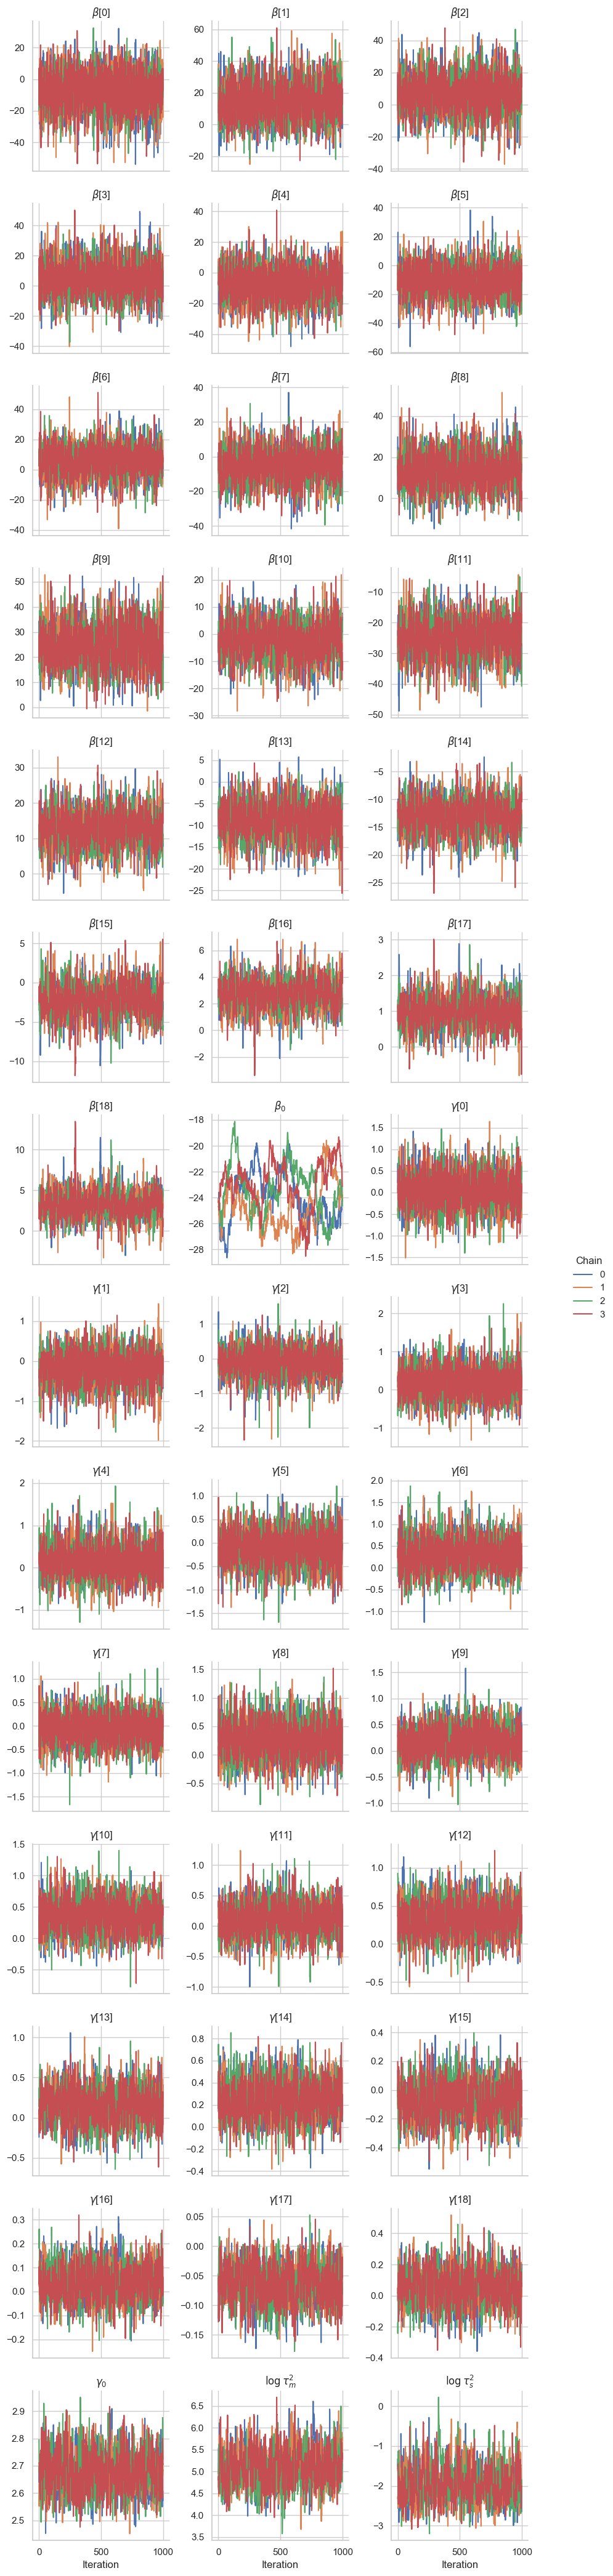

In [15]:
gs.plot_trace(results)

## Predictions

In [16]:
samples = results.get_posterior_samples()

### Evaluate basis matrix for new x values

We again use the `SmoothCon` oject initialized above. This will internally call `mgcv`
to evaluate the basis matrix at the new x values, applying all the right reparameterizations 
automatically.

In [17]:
times_grid = jnp.linspace(mcycle.times.min(), mcycle.times.max(), 200)
B_times_grid = stimes.predict(data={"times": times_grid})

### Predict variables at new x values

In [18]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(times)", "s(times)", "$\\mu$", "$\\sigma$"],
    newdata={"B(times)": B_times_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["times"] = np.tile(times_grid, len(predictions))

In [19]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,times
0,$\mu$,$\mu$[0],"(0,)",4000,-0.445635,1.522719,1.233985,1.001639,3393.313572,2803.745195,0.021356,0.032511,-2.341820,-0.480721,1.607932,-2.450615,1.474102,2.400000
1,$\mu$,$\mu$[1],"(1,)",4000,-0.856529,0.918134,0.958193,1.002986,3683.130175,2620.778298,0.015920,0.027877,-2.332574,-0.872399,0.670902,-2.209057,0.793707,2.677387
2,$\mu$,$\mu$[2],"(2,)",4000,-1.229003,0.628779,0.792956,1.001356,3626.912772,2507.776411,0.013272,0.023741,-2.463654,-1.229427,-0.018765,-2.491827,-0.059261,2.954774
3,$\mu$,$\mu$[3],"(3,)",4000,-1.556849,0.517521,0.719390,1.001128,3495.555867,2413.157029,0.012398,0.019857,-2.685984,-1.555460,-0.430827,-2.724714,-0.473658,3.232161
4,$\mu$,$\mu$[4],"(4,)",4000,-1.835671,0.503313,0.709446,1.001524,3447.494961,2868.470229,0.012287,0.016807,-2.952847,-1.833513,-0.720162,-2.969341,-0.750420,3.509548


### Plot fitted functions

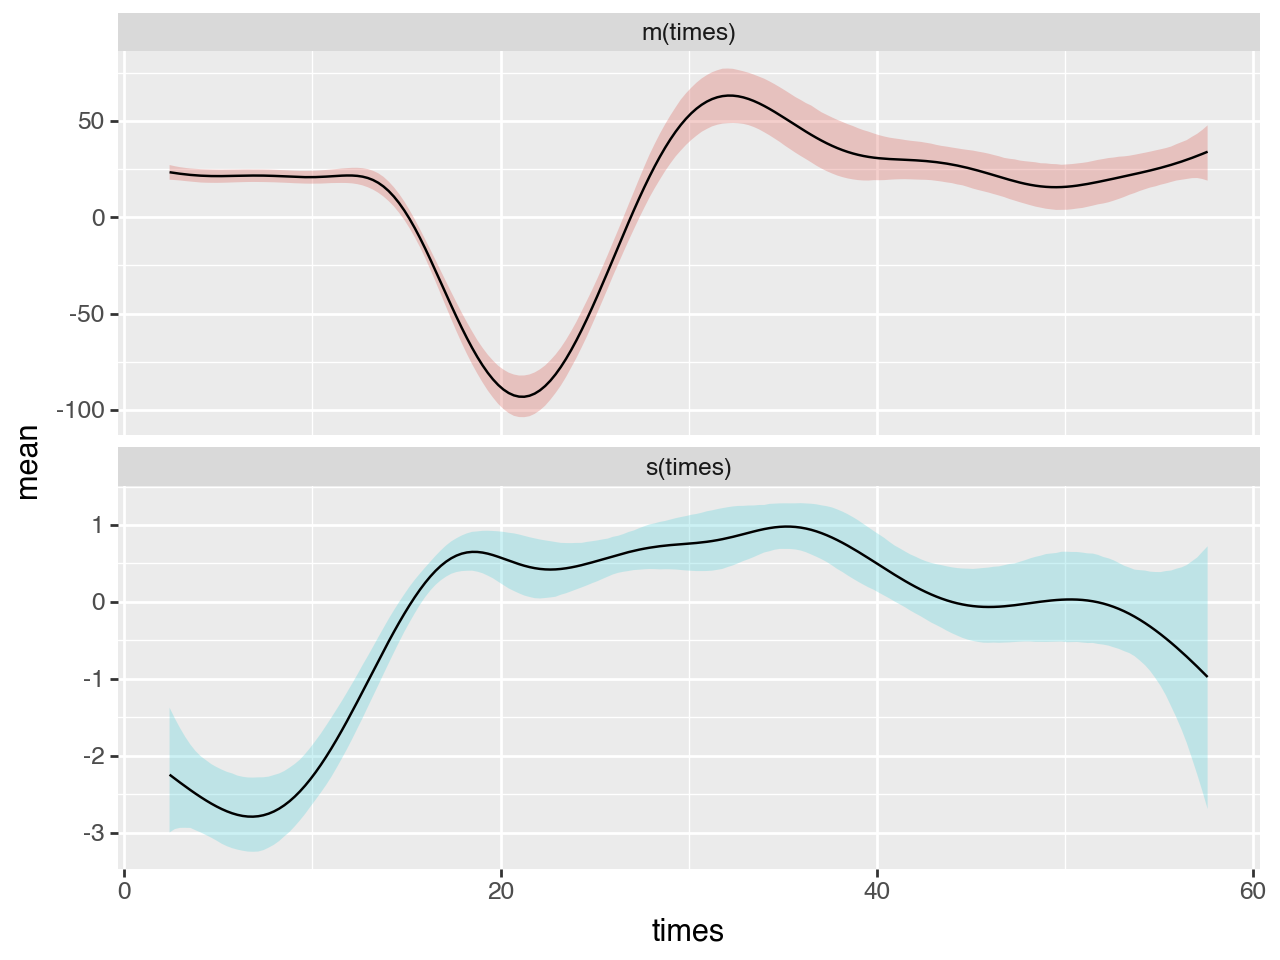

In [20]:
select = predictions_summary["variable"].isin(["s(times)", "m(times)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("times", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("times", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

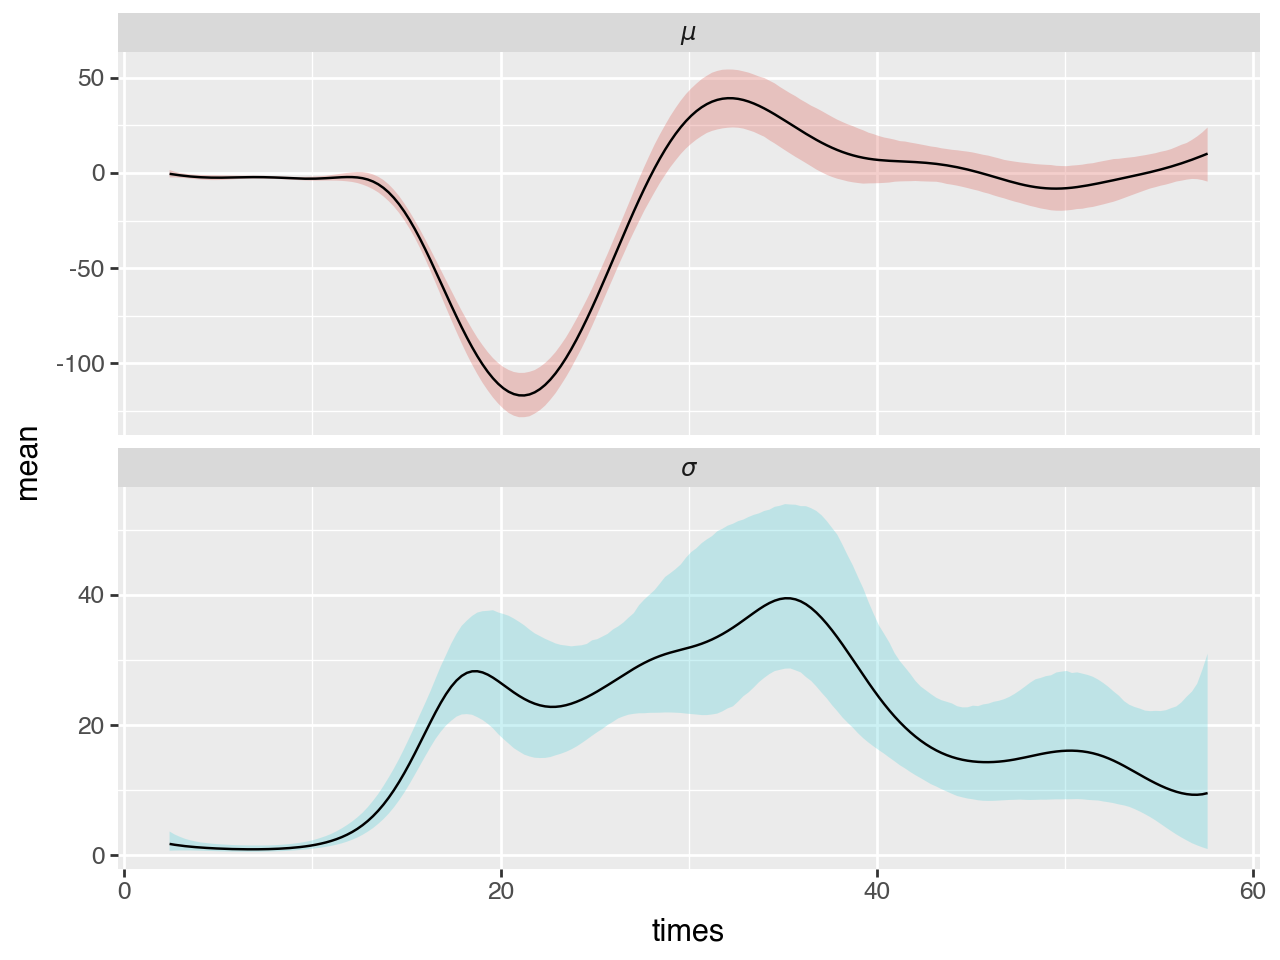

In [21]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("times", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("times", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

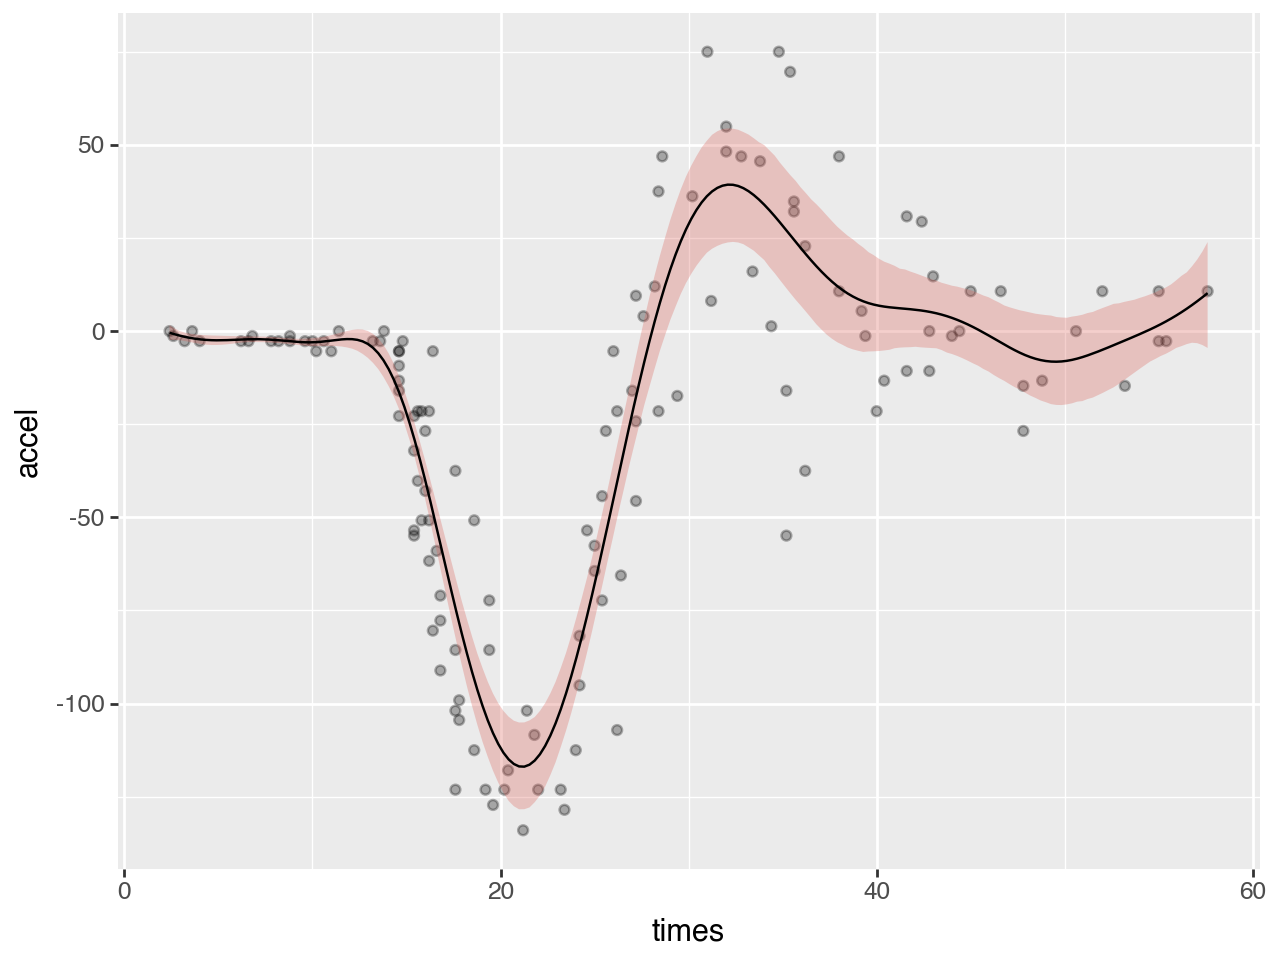

In [22]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("times", "accel"), data=mcycle, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("times", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("times", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [23]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "times"]]
    .pivot(index="times", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,times,$\mu$,$\sigma$,low,high
0,2.400000,-0.445635,1.765769,-2.211404,1.320135
1,2.677387,-0.856529,1.631406,-2.487936,0.774876
2,2.954774,-1.229003,1.518546,-2.747549,0.289544
3,3.232161,-1.556849,1.422786,-2.979635,-0.134063
4,3.509548,-1.835671,1.340762,-3.176434,-0.494909
...,...,...,...,...,...
195,56.490448,6.015355,9.406246,-3.390891,15.421601
196,56.767838,6.992316,9.319886,-2.327570,16.312202
197,57.045223,8.016466,9.309670,-1.293204,17.326138
198,57.322613,9.085760,9.386642,-0.300882,18.472403


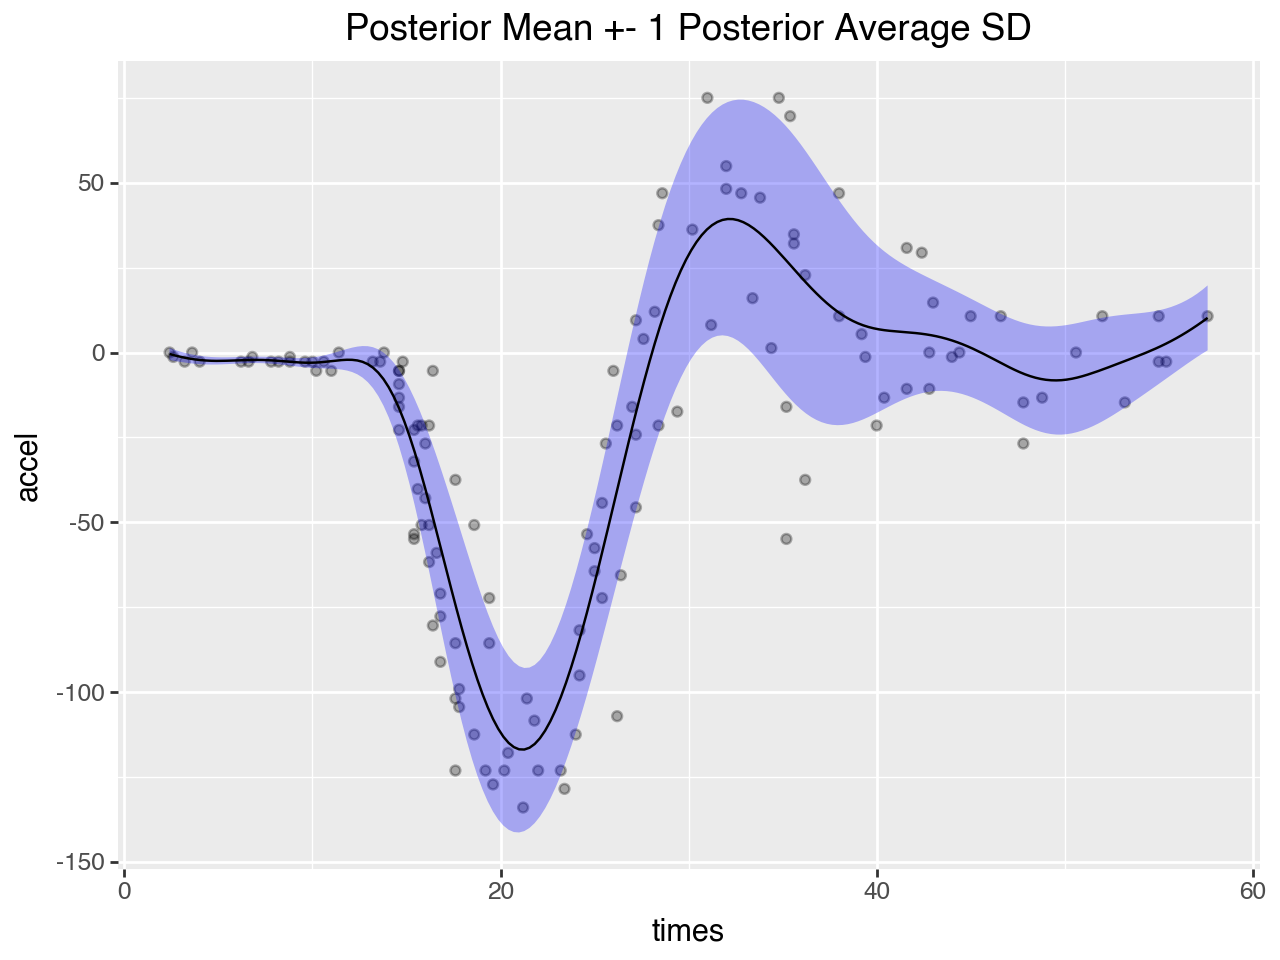

In [24]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("times", "accel"), data=mcycle, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("times", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("times", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [25]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["accel"].shape

(3, 4, 1000, 133)

In [26]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["accel"].reshape(-1, *ppsamples["accel"].shape[2:])

### Summarize posterior predictive samples

In [27]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["times"] = mcycle["times"].to_numpy()

### Plot posterior predictive summary

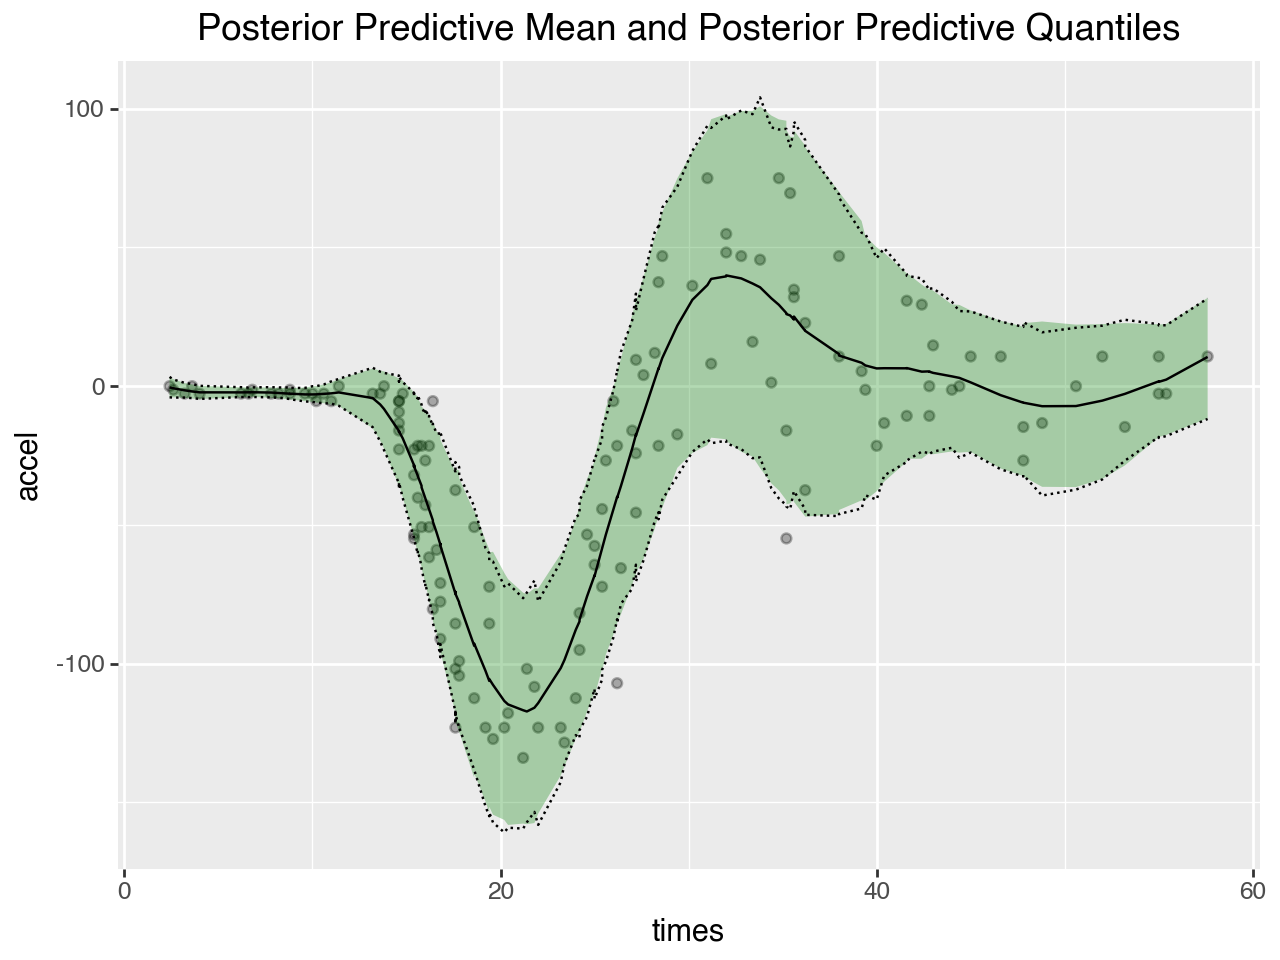

In [28]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("times", "accel"), data=mcycle, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("times", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("times", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("times", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("times", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

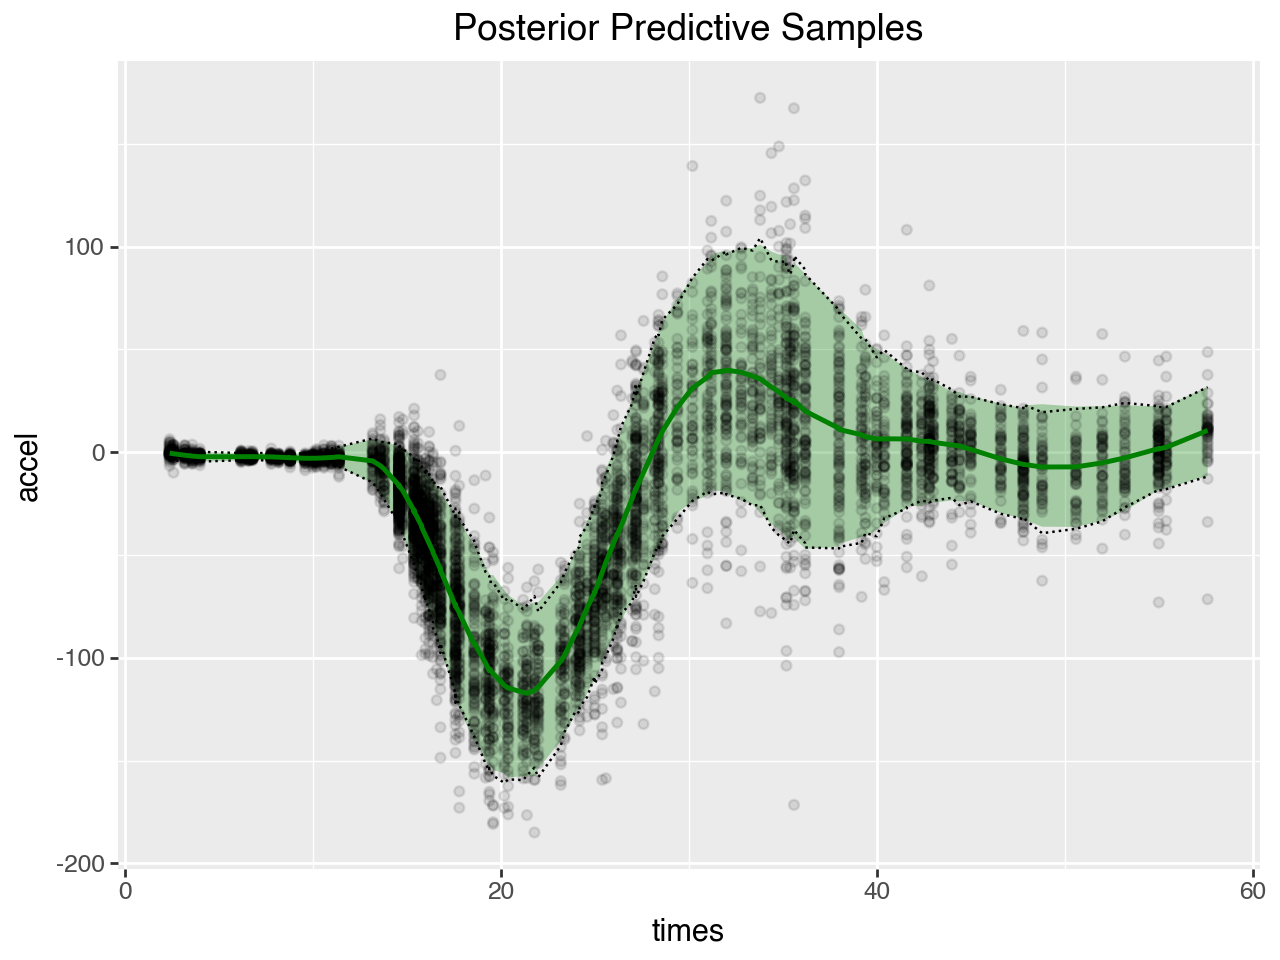

In [29]:
ppsamples_reshaped = ppsamples["accel"].reshape(-1, *ppsamples["accel"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["times"] = mcycle["times"].to_numpy()
ppsamples_df = ppsamples_df.melt(
    id_vars=["times"], value_name="accel", var_name="sample"
)
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("times", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("times", "accel"), alpha=0.1)
    + p9.geom_line(
        p9.aes("times", "hdi_low"), linetype="dotted", data=ppsamples_summary
    )
    + p9.geom_line(
        p9.aes("times", "hdi_high"), linetype="dotted", data=ppsamples_summary
    )
    + p9.geom_line(
        p9.aes("times", "mean"), color="green", size=1, data=ppsamples_summary
    )
)